In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import LabelEncoder
import umap
from sklearn.model_selection import train_test_split

In [27]:
# Reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Plotting config
sns.set_style("white")
plt.rcParams['figure.dpi'] = 100

In [28]:
gex = pd.read_csv('/Users/dana/Desktop/AHI/01_PAML/Project/scr/data/mammacarcinoma_gex.csv', index_col=0)
patinfo = pd.read_csv('/Users/dana/Desktop/AHI/01_PAML/Project/scr/data/mammacarcinoma_pat.csv', index_col=0)

In [29]:
# merge metadata + gene expression by patient_id
data = patinfo.merge(gex, on="patient_id")

# define target
target_col = "er"
y = data[target_col]
X = data.drop(columns=[target_col])

In [30]:
print(X.shape)
print(y.shape)

(327, 6389)
(327,)


In [31]:
# Remove samples with missing target 
mask = y.notna()
X = X.loc[mask]
y = y.loc[mask]

In [32]:
print(f"Removed {len(mask) - mask.sum()} samples with missing labels.")

Removed 19 samples with missing labels.


In [33]:
print(X.shape)
print(y.shape)

(308, 6389)
(308,)


In [34]:
X

,node,grade,size,age,relapse,DDR1,RFC2,HSPA6,PAX8,GUCA1A,...,CASP8AP2,POLM,KLK5,SH3BP4,SPO11,TRDN,DKFZP564C196,YDD19,TAZ,GMEB2
patient_id,,,,,,,,,,,,,,,,,,,,,
0,0.0,NaN,0.0,44.0,0.0,9.2048,6.3038,7.7602,7.9725,4.26530,...,5.8878,2.5847,6.1013,8.4443,3.151000,1.83220,3.38240,3.7738,5.6098,7.2277
1,0.0,NaN,0.3,61.0,0.0,10.0090,5.8149,6.7343,7.9232,3.50110,...,6.7993,5.5474,6.3789,8.3950,3.133900,1.90000,3.25240,3.2802,6.2927,7.2210
2,0.0,NaN,1.5,53.0,0.0,8.6175,5.9355,5.8762,6.5176,2.53460,...,6.5924,4.5240,7.2288,8.0967,3.149900,-1.16120,2.68950,3.6827,5.5525,6.6015
3,0.0,3.0,3.0,62.0,1.0,9.6734,7.0122,5.5486,8.0859,4.28850,...,6.5698,4.6732,5.3107,9.1025,3.112300,-0.63409,2.66560,3.4840,6.4214,7.7900
4,NaN,3.0,NaN,NaN,0.0,9.0900,6.0937,6.6429,7.9868,3.27290,...,5.7934,5.0880,5.2918,7.3995,4.138500,-0.47459,-0.89478,2.7115,6.4785,7.1017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
322,0.0,2.0,2.5,69.0,NaN,9.6058,5.6191,6.8271,7.8933,5.17700,...,6.4481,4.9890,5.0753,8.7309,4.053800,2.65610,3.46090,2.0747,6.3080,7.1414
323,NaN,1.0,NaN,NaN,NaN,9.5777,6.1209,6.1702,6.9966,4.01260,...,5.6446,3.9242,6.2588,8.3053,2.981300,3.80950,3.76110,4.4177,5.6289,6.6664
324,0.0,2.0,2.1,40.0,0.0,8.7979,5.2583,5.8413,7.7988,4.92420,...,6.2356,3.9251,5.0435,8.9658,5.158400,1.15010,0.82005,2.5920,6.3487,7.3176


In [35]:
# identify gene expression columns (all genes except metadata)
meta_cols = ["node", "grade", "size", "age","relapse", "patient_id"]  # patient_id for merging drop later
gene_cols = [c for c in X.columns if c not in meta_cols]

In [36]:
# drop patient_id from features after merging
meta_cols_no_id = ["node", "grade", "size", "age","relapse"]

In [37]:
# split into train, temp, test (stratify on target)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, stratify=y, random_state=42)

# split temp into validation and test
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

In [38]:
# extract gene expression and metadata subsets
X_train_gene = X_train[gene_cols]
X_val_gene = X_val[gene_cols]
X_test_gene = X_test[gene_cols]

X_train_meta = X_train[meta_cols_no_id]
X_val_meta = X_val[meta_cols_no_id]
X_test_meta = X_test[meta_cols_no_id]

In [39]:
# scale gene expression data
gene_scaler = StandardScaler()
X_train_gene_scaled = gene_scaler.fit_transform(X_train_gene)
X_val_gene_scaled = gene_scaler.transform(X_val_gene)
X_test_gene_scaled = gene_scaler.transform(X_test_gene)

In [40]:
X_train_gene_scaled

array([[-0.96037125,  1.68093133, -1.23596796, ...,  1.39991169,
        -0.35074026, -0.36011643],
       [ 0.92951383,  0.04183   , -0.01448924, ...,  0.53094871,
         1.23945018,  1.45172577],
       [ 0.26481044,  0.80527165,  0.05699797, ...,  1.90601244,
         0.51388331, -0.97610992],
       ...,
       [ 0.50211933, -0.20738379,  0.41720842, ..., -2.00425567,
         1.05867649,  0.79490071],
       [ 0.44058597, -1.49187616, -0.23496208, ...,  0.49399657,
         0.47340236,  1.17951531],
       [ 2.7311534 , -1.07747745,  0.80266597, ..., -0.76629354,
         0.53273321,  2.54197559]], shape=(184, 6384))

In [ ]:
# fit full PCA for plotting
pca_full = PCA(random_state=42)
pca_full.fit(X_train_gene_scaled)

explained_var = pca_full.explained_variance_ratio_
cum_var = np.cumsum(explained_var)

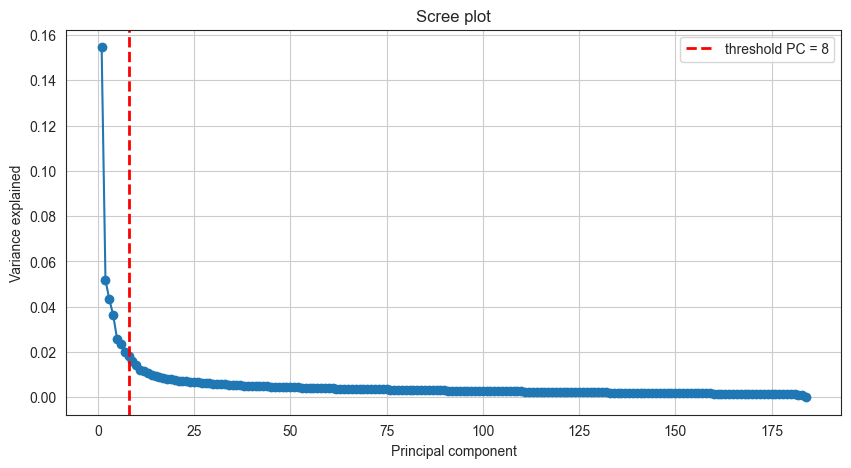

In [47]:
# create scree plot and save
plt.figure(figsize=(10, 5))
plt.plot(np.arange(1, len(explained_var) + 1), explained_var, marker='o')
plt.axvline(x=8, color='r', linestyle='--', linewidth=2, label='threshold PC = 8')
plt.title("Scree plot")
plt.xlabel("Principal component")
plt.ylabel("Variance explained")
plt.grid(True)
plt.legend()
plt.savefig("scree_plot.png", dpi=300)
plt.show()

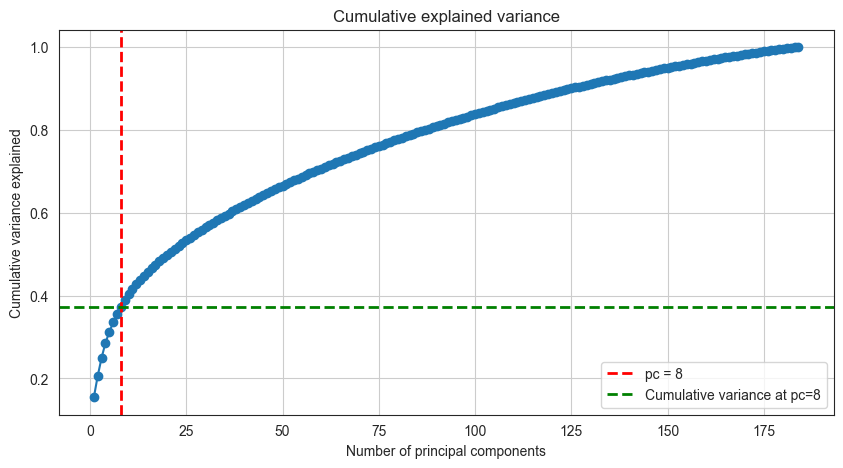

In [48]:
# create cumulative variance plot and save
plt.figure(figsize=(10, 5))
plt.plot(np.arange(1, len(cum_var) + 1), cum_var, marker='o')
plt.axvline(x=8, color='r', linestyle='--', linewidth=2, label='pc = 8')
plt.axhline(y=cum_var[7], color='g', linestyle='--', linewidth=2, label='Cumulative variance at pc=8')
plt.title("Cumulative explained variance")
plt.xlabel("Number of principal components")
plt.ylabel("Cumulative variance explained")
plt.grid(True)
plt.legend()
plt.savefig("cumulative_variance_plot.png", dpi=300)
plt.show()

In [49]:
cumvar = np.cumsum(pca_full.explained_variance_ratio_)
print(f"PC1-8 explain {cumvar[7]*100:.1f}% variance")

PC1-8 explain 37.4% variance


In [52]:
# select pc = 8 for final transformation
pca_final = PCA(n_components=8, random_state=42)
X_train_pca = pca_final.fit_transform(X_train_gene_scaled)
X_val_pca = pca_final.transform(X_val_gene_scaled)
X_test_pca = pca_final.transform(X_test_gene_scaled)

# scale metadata separately
meta_scaler = StandardScaler()
X_train_meta_scaled = meta_scaler.fit_transform(X_train_meta)
X_val_meta_scaled = meta_scaler.transform(X_val_meta)
X_test_meta_scaled = meta_scaler.transform(X_test_meta)

# concatenate pca components with scaled metadata
X_train_final = np.hstack([X_train_pca, X_train_meta_scaled])
X_val_final = np.hstack([X_val_pca, X_val_meta_scaled])
X_test_final = np.hstack([X_test_pca, X_test_meta_scaled])

print("train final shape:", X_train_final.shape)
print("validation final shape:", X_val_final.shape)
print("test final shape:", X_test_final.shape)

train final shape: (184, 13)
validation final shape: (62, 13)
test final shape: (62, 13)


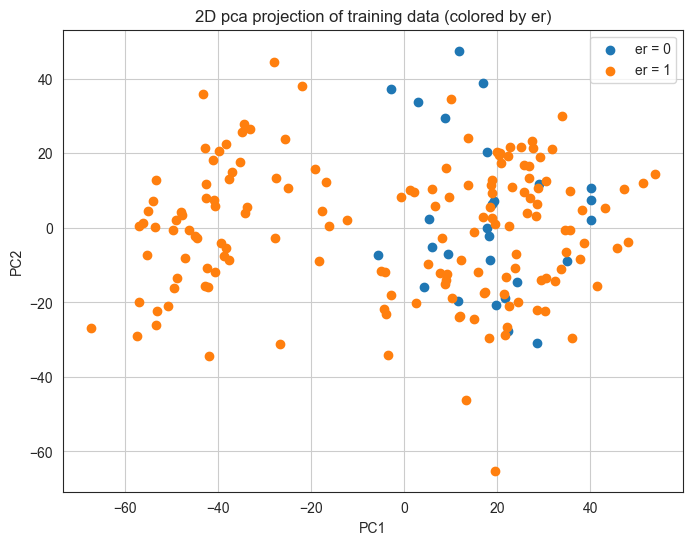

In [53]:
# project training data into pca space (first two components)
pc1 = X_train_pca[:, 0]
pc2 = X_train_pca[:, 1]

# convert y_train to numpy array for indexing
y_train_array = np.array(y_train)

# create 2d scatter plot
plt.figure(figsize=(8, 6))

# plot er = 0
plt.scatter(
    pc1[y_train_array == 0],
    pc2[y_train_array == 0],
    label='er = 0',
)

# plot er = 1
plt.scatter(
    pc1[y_train_array == 1],
    pc2[y_train_array == 1],
    label='er = 1',
)

# axis labels and title
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("2D pca projection of training data (colored by er)")
plt.legend()
plt.grid(True)
plt.show()

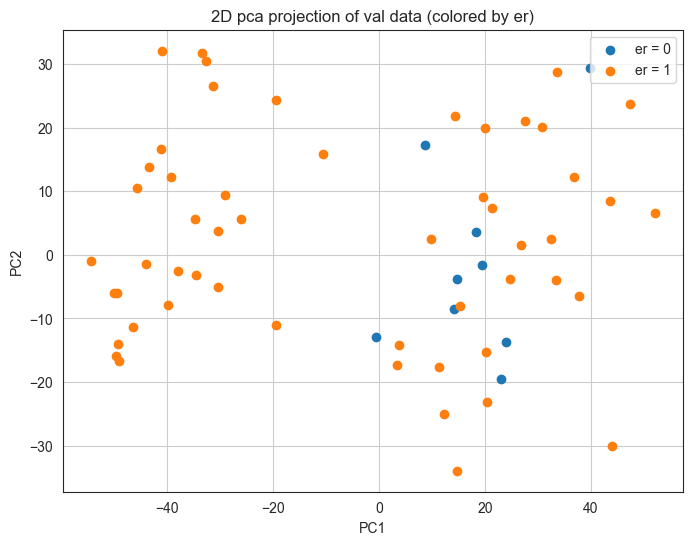

In [54]:
# project val data into pca space (first two components)
pc1 = X_val_pca[:, 0]
pc2 = X_val_pca[:, 1]

# convert y_val to numpy array for indexing
y_val_array = np.array(y_val)

# create 2d scatter plot
plt.figure(figsize=(8, 6))

# plot er = 0
plt.scatter(
    pc1[y_val_array == 0],
    pc2[y_val_array == 0],
    label='er = 0',
)

# plot er = 1
plt.scatter(
    pc1[y_val_array == 1],
    pc2[y_val_array == 1],
    label='er = 1',
)

# axis labels and title
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("2D pca projection of val data (colored by er)")
plt.legend()
plt.grid(True)
plt.show()

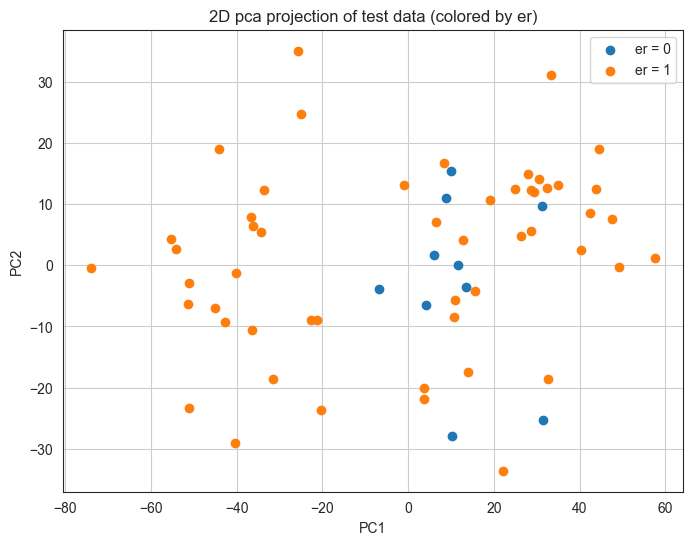

In [55]:
# project val data into pca space (first two components)
pc1 = X_test_pca[:, 0]
pc2 = X_test_pca[:, 1]

# convert y_test to numpy array for indexing
y_test_array = np.array(y_test)

# create 2d scatter plot
plt.figure(figsize=(8, 6))

# plot er = 0
plt.scatter(
    pc1[y_test_array == 0],
    pc2[y_test_array == 0],
    label='er = 0',
)

# plot er = 1
plt.scatter(
    pc1[y_test_array == 1],
    pc2[y_test_array == 1],
    label='er = 1',
)

# axis labels and title
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("2D pca projection of test data (colored by er)")
plt.legend()
plt.grid(True)
plt.show()

# UMAP

/Users/dana/anaconda3/envs/ahi/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


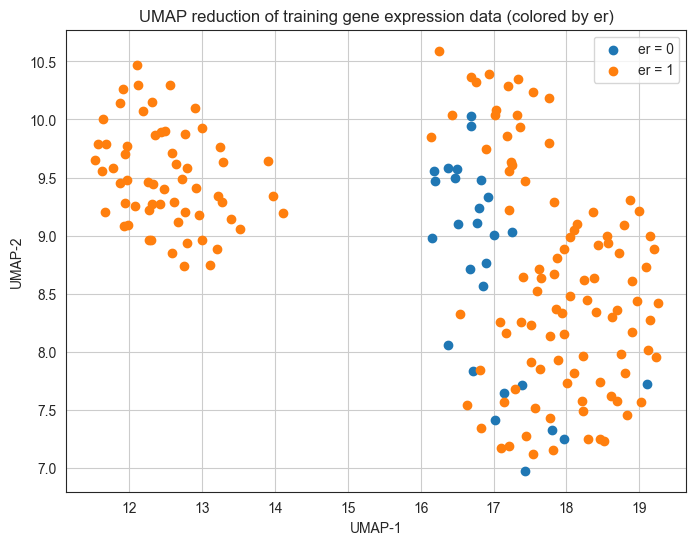

In [67]:
# fit umap on scaled gene expression training data
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)

X_train_umap = umap_model.fit_transform(X_train_gene_scaled)

# extract umap coordinates
u1 = X_train_umap[:, 0]
u2 = X_train_umap[:, 1]

# convert y_train to numpy array
y_train_array = np.array(y_train)

# plot umap embedding
plt.figure(figsize=(8, 6))

# er = 0
plt.scatter(
    u1[y_train_array == 0],
    u2[y_train_array == 0],
    label='er = 0')

# er = 1
plt.scatter(
    u1[y_train_array == 1],
    u2[y_train_array == 1],
    label='er = 1')

plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.title("UMAP reduction of training gene expression data (colored by er)")
plt.legend()
plt.grid(True)
plt.show()

In [64]:
# In case I choose UMAP as dim red method
# X_val_umap = umap_model.transform(X_val_gene_scaled)
# X_test_umap = umap_model.transform(X_test_gene_scaled)

# tSNE

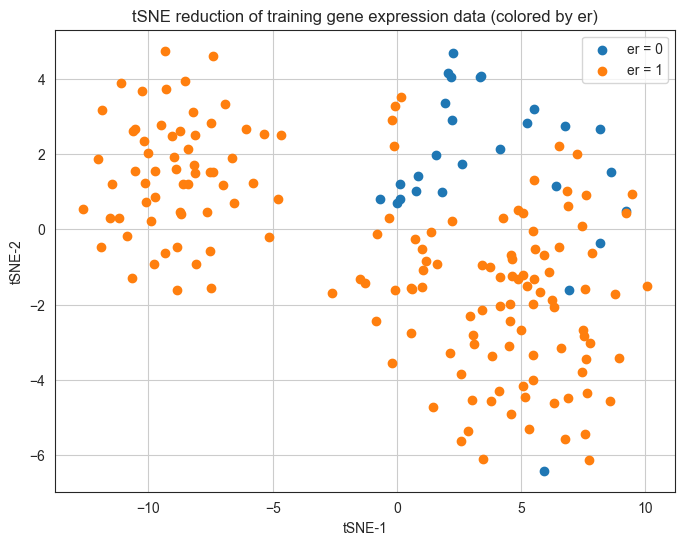

In [66]:

# fit tsne on scaled gene expression training data
tsne_model = TSNE(n_components=2,perplexity=30,learning_rate='auto',init='pca',random_state=42)

X_train_tsne = tsne_model.fit_transform(X_train_gene_scaled)

# extract tsne coordinates
t1 = X_train_tsne[:, 0]
t2 = X_train_tsne[:, 1]

# convert y_train to numpy array
y_train_array = np.array(y_train)

# plot tsne embedding
plt.figure(figsize=(8, 6))

# er = 0
plt.scatter(
    t1[y_train_array == 0],
    t2[y_train_array == 0],
    label='er = 0')

# er = 1
plt.scatter(
    t1[y_train_array == 1],
    t2[y_train_array == 1],
    label='er = 1')

plt.xlabel("tSNE-1")
plt.ylabel("tSNE-2")
plt.title("tSNE reduction of training gene expression data (colored by er)")
plt.legend()
plt.grid(True)
plt.show()

# Evaluation of the dim. red. methods based on silhouette score

In [59]:
# Prepare data for plotting
y_train_array = np.array(y_train)
embeddings = {
    'PCA': X_train_pca[:, :8],
    'UMAP': X_train_umap,
    't-SNE': X_train_tsne
}

In [60]:
results = []

for method_name, coords in embeddings.items():
    # for PCA, coords are first 8 PCs
    # for UMAP and t-SNE, coords are already 2D
    eval_coords = coords
    
    score = silhouette_score(eval_coords, y_train_array, metric='euclidean')
    results.append({'Method': method_name, 'Silhouette Score': score})
    print(f"{method_name:8s}: {score:.3f}")

PCA     : 0.079
UMAP    : -0.099
t-SNE   : -0.003


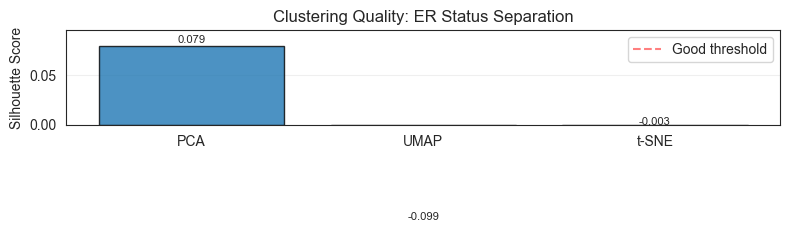


 Optimal method for ER separation: PCA


In [62]:
# Visualize scores
results_df = pd.DataFrame(results)
plt.figure(figsize=(8, 7))
bars = plt.bar(results_df['Method'], results_df['Silhouette Score'], 
              color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'],
              edgecolor='black', alpha=0.8)
plt.ylabel('Silhouette Score')
plt.title('Clustering Quality: ER Status Separation')
plt.ylim(0, max(results_df['Silhouette Score']) * 1.2)
plt.axhline(0.5, color='red', linestyle='--', alpha=0.5, label='Good threshold')
plt.legend()
plt.grid(axis='y', alpha=0.3)

# Add value labels
for bar, score in zip(bars, results_df['Silhouette Score']):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
            f'{score:.3f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.savefig('part1_silhouette_scores.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n Optimal method for ER separation: {results_df.loc[results_df['Silhouette Score'].idxmax(), 'Method']}")

# Saveing the data

In [69]:
# create column names for pca components
pca_cols = [f"pc{i+1}" for i in range(8)]
meta_cols = ["node", "grade", "size", "age","relaps"]

# combine pca + metadata for train
X_train_final = np.hstack([X_train_pca, X_train_meta_scaled])
df_train = pd.DataFrame(X_train_final, columns=pca_cols + meta_cols)
df_train["er"] = y_train.values   # include target
df_train.to_csv("train_pca_data.csv", index=False)

# combine pca + metadata for validation
X_val_final = np.hstack([X_val_pca, X_val_meta_scaled])
df_val = pd.DataFrame(X_val_final, columns=pca_cols + meta_cols)
df_val["er"] = y_val.values       
df_val.to_csv("val_pca_data.csv", index=False)

# combine pca + metadata for test
X_test_final = np.hstack([X_test_pca, X_test_meta_scaled])
df_test = pd.DataFrame(X_test_final, columns=pca_cols + meta_cols)
df_test["er"] = y_test.values  
df_test.to_csv("test_pca_data.csv", index=False)